# ROB 498-011/599-011 Final Project: Mip-NeRF Object Gesture Control

Michael Guertler, Sagar Patil, Adithya Ramakrishnan, Tyler Smithline

# Setup


In [ ]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
running_colab = 'google.colab' in str(get_ipython())

if running_colab:
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print('Running locally')

Mounted at /content/drive


In [ ]:
import os, sys
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import time
import cv2
import math
from IPython.display import display, Javascript, Image, clear_output
from google.colab.output import eval_js
from base64 import b64decode
from google.colab.patches import cv2_imshow

if running_colab:
    GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None

    # Add your own path here and comment out the others when you run this
    GOOGLE_DRIVE_PATH = os.path.join("drive", "My Drive", "599 - Deep Learning/Final Project") # Michael
    # GOOGLE_DRIVE_PATH = os.path.join("drive", "My Drive", "ROB 599 Deep Learning Rob Perception/Final Project/Mip-NeRF") # Adithya

print(os.listdir(GOOGLE_DRIVE_PATH))

# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device is set to: ', device)

['tiny_nerf_data.npz', 'Group 4 - NeRF, DeepRob Paper Presentation.gslides', 'Mip-NeRF', 'TinyNeRF', 'Video Resources', 'P4-20240428T155239Z-001.zip', 'Image Preload', 'TinyNeRF_GestureControl.ipynb', 'MipNeRF_GestureControl.ipynb']
Device is set to:  cuda


# Mip-NeRF Implementation

## Training


In [ ]:
# Change the current working directory to your Google Drive path
os.chdir('/content/drive/My Drive/599 - Deep Learning/Final Project/Mip-NeRF') # Michael
# os.chdir('/content/drive/MyDrive/ROB 599 Deep Learning Rob Perception/Final Project') # Adithya

!python train.py

2024-04-28 15:39:59.251153: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 15:39:59.251209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 15:39:59.252574: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-28 15:39:59.259953: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-28 15:40:00.300195: W tensorflow/compiler/tf2

## Visualization


In [ ]:
# Change the current working directory to your Google Drive path
os.chdir('/content/drive/My Drive/599 - Deep Learning/Final Project/Mip-NeRF') # Michael
#os.chdir('/content/drive/MyDrive/ROB 599 Deep Learning Rob Perception/Final Project') # Adithya

!python visualize.py

Generating Render Poses
Generating rays
Done

Generating Video using 120 different view points
 91% 109/120 [3:13:08<19:33, 106.64s/it]

## Rendering Mesh


In [ ]:
# Change the current working directory to your Google Drive path
os.chdir('/content/drive/My Drive/599 - Deep Learning/Final Project/Mip-NeRF') # Michael

!python extract_mesh.py

python3: can't open file '/content/drive/.shortcut-targets-by-id/1T1TY2qq-oKwmHnKAFRA0njTmO7Q3GcA6/599 - Deep Learning/Final Project/extract_mesh.py': [Errno 2] No such file or directory


# Gesture Control

##Import Dependencies

In [ ]:
os.chdir('/content/drive/My Drive/599 - Deep Learning/Final Project/Mip-NeRF') # Michael

#Import dependencies
from model import MipNeRF
import imageio
from datasets import get_dataloader
from tqdm import tqdm
from pose_utils import visualize_depth, visualize_normals, to8b
import argparse
import torch
from os import path
from easydict import EasyDict
from config import get_config

In [ ]:
# os.chdir('/content/drive/MyDrive/ROB 599 Deep Learning Rob Perception/Final Project/Mip-NeRF') # Adithya
os.chdir('/content/drive/My Drive/599 - Deep Learning/Final Project/Mip-NeRF') # Michael

#Load and initialize the model
config = get_config()

## Hand tracking setup


In [ ]:
!pip install mediapipe
import mediapipe as mp

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands()

# Create functions that will allow for gesture control
def take_photo(filename='photo.jpg', quality=0.3):
    js = Javascript('''
        async function takePhoto(quality) {
            const canvas = document.createElement('canvas');
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            const video = document.createElement('video');
            video.srcObject = stream;
            await video.play();
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            //stream.getVideoTracks()[0].stop();
            return canvas.toDataURL('image/jpeg', quality);
        }
        ''')

    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])

    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

#Transformation Matrices
N_samples = 64
trans_t = lambda t : torch.tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=torch.float32)

rot_phi = lambda phi : torch.tensor([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1],
], dtype=torch.float32)

rot_theta = lambda th : torch.tensor([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1],
], dtype=torch.float32)

# Define the pose_spherical function
def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w.numpy()
    return torch.tensor(c2w, dtype=torch.float32, device=device)

def render_image(theta, phi, radius):
    pR = radius
    pT = theta
    data = get_dataloader(config.dataset_name, config.base_dir, split="render", factor=config.factor, shuffle=False, poseRadius = pR, poseTheta = pT)
    model = MipNeRF(
    use_viewdirs=config.use_viewdirs,
    randomized=config.randomized,
    ray_shape=config.ray_shape,
    white_bkgd=config.white_bkgd,
    num_levels=config.num_levels,
    num_samples=config.num_samples,
    hidden=config.hidden,
    density_noise=config.density_noise,
    density_bias=config.density_bias,
    rgb_padding=config.rgb_padding,
    resample_padding=config.resample_padding,
    min_deg=config.min_deg,
    max_deg=config.max_deg,
    viewdirs_min_deg=config.viewdirs_min_deg,
    viewdirs_max_deg=config.viewdirs_max_deg,
    device=config.device,
    )

    model.load_state_dict(torch.load(config.model_weight_path))
    model.eval()
    return data, model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 40.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyl

## Mip-NeRF Gesture Control

Generating Render Poses
Generating rays
Done



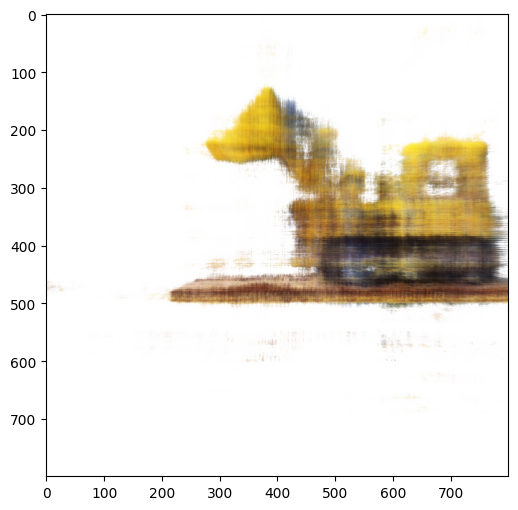

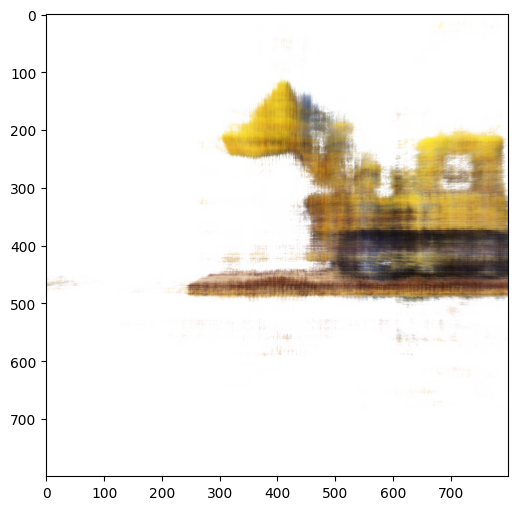

KeyboardInterrupt: 

In [ ]:
from IPython.display import Image

while(True):
    frame = cv2.imread(take_photo())

    # Convert the displayed image to a NumPy array
    frame = np.array(frame)

    # # Flip the frame horizontally to revert it to its original orientation
    frame = cv2.flip(frame, 1)  #makes movement mirrored and not flipped

    H_frame, W_frame, C_frame = frame.shape       #assume unchanged shape. Get frame sizes

    # Convert the image to RGB --> MediaPipe needs this format
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the image with MediaPipe
    results = hands.process(rgb_frame)


    clear_output(wait=True)

    # If hand(s) are detected, draw landmarks on the frame
    if results.multi_hand_landmarks:
        # for hand_landmarks in results.multi_hand_landmarks:    #this line annotates all visible hands. Indent lines below if kept
        hand_landmarks = results.multi_hand_landmarks[-1]         #ONLY detects/annotates the last hand. Keep either this or above line
        for idx, landmark in enumerate(hand_landmarks.landmark):
            # Convert normalized coordinates to pixel coordinates
            h, w, c = frame.shape
            cx, cy = int(landmark.x * w), int(landmark.y * h)

            # Draw a circle and number on each landmark
            #Only display dots (and text) for tip of index & thumb.
            if (idx == 4) or (idx == 8):
                cv2.circle(frame, (cx, cy), 5, (0, 255, 0), -1)

        # Get the pixel coordinates of landmarks 4 and 8
        index4_x, index4_y = int(hand_landmarks.landmark[4].x * w), int(hand_landmarks.landmark[4].y * h)
        index8_x, index8_y = int(hand_landmarks.landmark[8].x * w), int(hand_landmarks.landmark[8].y * h)

        # calculate length of line between 4,8
        line_dist = math.sqrt((index4_x-index8_x)**2 + (index4_y-index8_y)**2)

        # Get median point of line between 4,8 --> point that will be tracked
        median_x = int((index4_x + index8_x)/2)
        median_y = int((index4_y + index8_y)/2)

        #Convert median point coordinates to theta, phi, radius values. Range values used from P4
        theta = ((median_x - 0.2*W_frame) / (0.8*W_frame - 0.2*W_frame)) * 360
        theta = max(0, min(360, theta))
        phi = ((median_y - 0.2*H_frame) / (0.8*H_frame - 0.2*H_frame)) * ((-90) - 0) + 0 # map y_position from 0.2*H-0.8*H to [-90, 0]
        phi = max(-90, min(0, phi))                                 # values < 0.2*H = -90. values > 0.8*H = 0. Prevent hand from leaving screen just to reach these limits
        radius = min( ((line_dist/250 * (5 - 3)) + 3), 5)      # ^^. Map to range [3, 5]

        # Get data and model from our input variables
        data, model = render_image(theta, phi, radius)

        for ray in data:
            # Render Image
            img, dist, acc = model.render_image(ray, data.h, data.w, chunks=config.chunks)

            # Show the image
            plt.figure(2, figsize=(20,6))
            plt.imshow(img)
            plt.show()

        # Draw a line between landmarks 4 and 8
        cv2.line(frame, (index4_x, index4_y), (index8_x, index8_y), (255, 0, 0), 2)
        # Draw the median point (should lie on the center of the line)
        cv2.circle(frame, (median_x, median_y), 5, (0, 0, 255), -1)
        cv2.putText(frame, "Theta = " + str(theta), (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2) #Display text -- Theta
        cv2.putText(frame, "Phi = " + str(phi), (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2) #Display text -- Phi
        cv2.putText(frame, "Radius = " + str(radius), (10, 250), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2) #Display text -- Line_dist

        # Draw lines to show effective tracking area of screen. (Width: 0*W_frame - 0.8*W_frame) (Height: 0.2*H_frame - 0.8*H_frame)
        cv2.line(frame, (int(0.2*W_frame), int(0.2*H_frame)), (int(0.8*W_frame), int(0.2*H_frame)), (0, 0, 0), 2)     # top horizontal line    @ 0.2*H_frame
        cv2.line(frame, (int(0.2*W_frame), int(0.8*H_frame)), (int(0.8*W_frame), int(0.8*H_frame)), (0, 0, 0), 2)     # bottom horizontal line @ 0.8*H_frame
        cv2.line(frame, (int(0.2*W_frame), int(0.2*H_frame)), (int(0.2*W_frame), int(0.8*H_frame)), (0, 0, 0), 2)     # right vertical line    @ 0.8*W_frame
        cv2.line(frame, (int(0.8*W_frame), int(0.2*H_frame)), (int(0.8*W_frame), int(0.8*H_frame)), (0, 0, 0), 2)     # right vertical line    @ 0.8*W_frame

    # Display the annotated frame
    cv2_imshow(frame)